In [43]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

from sklearn.decomposition import PCA

import seaborn as sns
import ncvis
import os
import numpy as np
import sys
sys.path.append("..")
from vis_utils.loaders import load_pendigits
from vis_utils.utils import  save_dict, load_dict, kNN_graph, find_ab_params, compute_low_dim_sims

import scipy.sparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


**PenDigits** is a rather small dataset (<10k samples) of hand-written digits. Their apparent clusters are corresponding to the actual numbers, and we assume them to be easily distinguished.

In [44]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"
# get data
x, y  = load_pendigits(root_path)

# NCVis


In [49]:
# parameters for all methods
n_epochs = 5000
seed = 0
n_noise = 5
alpha_Q = 0.001
alpha = 1.0


## No noise, no damped Q

In [50]:
fix_Q = False
fix_noise = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               fix_noise=fix_noise,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


In [92]:
cmap = matplotlib.cm.get_cmap("tab10")

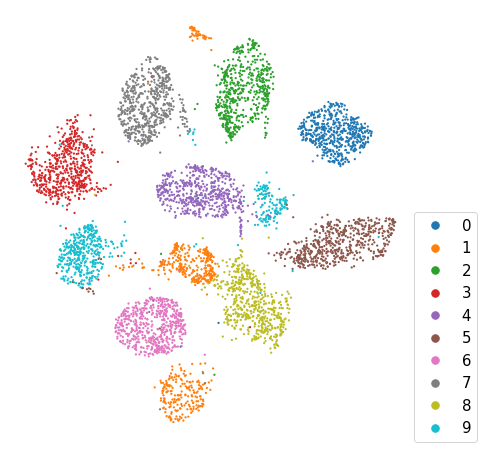

In [93]:
epoch = -1

plt.figure(figsize=(8,8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

43402.72
0.001390605793263606


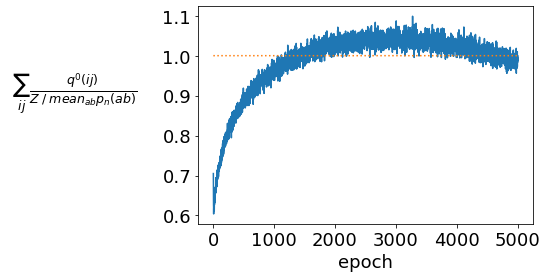

In [51]:
# relative normalization divided by the avg noise distribution, which is
# d_avg / (2 * (n-1) * |edges|)  = 1 / ((n-1) * n),
# since |edges| already counts every edge twice, as edges contains both directions for every edge
plt.figure()
plt.rcParams['font.size'] = 18
rel_norm =  ncvis_data["normalization"][1:] / np.exp(ncvis_data["qs"])[1:] / ((len(x)-1)*len(x))
plt.plot(rel_norm)

# smooth the signal
#box_pts=51
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)),
#         rel_norm_smooth)
#
plt.plot(np.ones(len(ncvis_data["normalization"]-1)), linestyle="dotted")


plt.xlabel("epoch")
plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z \;/ \; mean_{ab}p_n(ab)} $", rotation=0, labelpad = 90)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

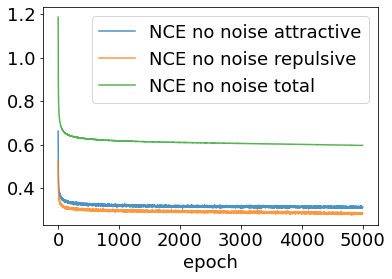

In [45]:

# the losses with true and learnt normalisation constant are very close
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 0]+ncvis_data["nce_loss_no_noise"][1:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 0]+ncvis_data["nce_loss_norm"][1:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
#plt.yscale("log")

plt.xlabel("epoch")

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_losses_no_noise_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

Final KL div 1.9170011485916962
Best KL div at iteration 4998 of value 1.9170009960720726


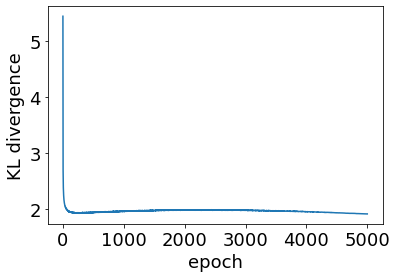

In [26]:
plt.plot(ncvis_data["kl_div"])
#plt.yscale("log")

print(f"Final KL div {ncvis_data['kl_div'][-1]}")
print(f"Best KL div at iteration {ncvis_data['kl_div'].argmin()} of value {ncvis_data['kl_div'].min()}")

plt.xlabel("epoch")
plt.ylabel("KL divergence")

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_KL_div_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

#### Check kNN graph

In [11]:
k=15
knn_graph = kNN_graph(x.astype("float"),
                      k,
                      metric="correlation").cpu().numpy().flatten()
knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*k),
                                     (np.repeat(np.arange(x.shape[0]), k),
                                      knn_graph)),
                                    shape=(len(x), len(x)))
sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()


In [12]:
sknn_graph_ncvis = scipy.sparse.coo_matrix((np.ones(len(ncvis_data["edges"])),
                                    (ncvis_data["edges"][:, 0],
                                     ncvis_data["edges"][:, 1])),
                                   shape=(len(x), len(x)))



In [13]:
print(f"Size sknn graph keops: {sknn_graph_ncvis.nnz}")
print(f"Size sknn graph ncvis: {sknn_graph_ncvis.nnz}")
intersection = sknn_graph.minimum(sknn_graph_ncvis).sum()

# delete duplicates in kNN graph of NCVis
sknn_graph_ncvis_no_dup = sknn_graph_ncvis.copy()
sknn_graph_ncvis_no_dup.sum_duplicates()
row_dup = sknn_graph_ncvis_no_dup.row[sknn_graph_ncvis_no_dup.data > 1]
col_dup = sknn_graph_ncvis_no_dup.col[sknn_graph_ncvis_no_dup.data > 1]
print(f"Number of duplicates: {len(row_dup)}")
print(f"Number of duplicates with multiplicity: {(sknn_graph_ncvis_no_dup.data- 1).sum()}")

sknn_graph_ncvis_no_dup.data = np.ones(len(sknn_graph_ncvis_no_dup.data))
sknn_graph_ncvis_no_dup.eliminate_zeros()

union = sknn_graph.maximum(sknn_graph_ncvis_no_dup).sum()
print(f"Intersection between both graphs:{intersection}")
print(f"No dup union: {union}")
print(f"IoU: {intersection / union}")


Size sknn graph keops: 134224
Size sknn graph ncvis: 134224
Number of duplicates: 15987
Number of duplicates with multiplicity: 15987.0
Intersection between both graphs:117639.0
No dup union: 119888.0
IoU: 0.9812408247697851


### No noise and fix Q

In [14]:
fix_Q = True
fix_noise = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               fix_noise=fix_noise,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data

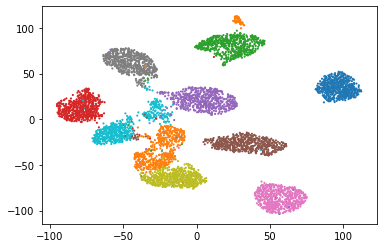

In [15]:
epoch = -1
plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=5, marker=".", cmap="tab10")



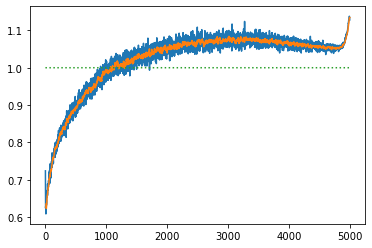

In [16]:
# relative normalization divided by the avg noise distribution, which is
# d_avg / (2 * (n-1) * |edges|)  = 1 / ((n-1) * n),
# since |edges| already counts every edge twice, as edges contains both directions for every edge

rel_norm =  ncvis_data["normalization"][1:] / np.exp(ncvis_data["qs"])[1:] / ((len(x)-1)*len(x))
plt.plot(rel_norm)
box_pts=11
box = np.ones(box_pts)/box_pts
rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)),rel_norm_smooth)
plt.plot(np.ones(len(ncvis_data["normalization"]-1)), linestyle="dotted")

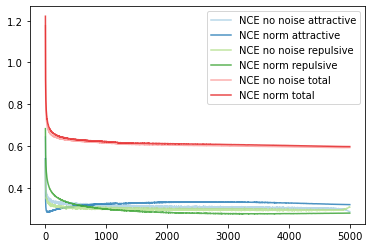

In [17]:
# the losses with true and learnt normalisation constant are very close
with sns.color_palette("Paired", n_colors=6):
    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 0],
             alpha=0.8,
             label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 1],
             alpha=0.8,
             label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss_no_noise"][1:, 0]+ncvis_data["nce_loss_no_noise"][1:, 1],
             alpha=0.8,
             label="NCE no noise total")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 0]+ncvis_data["nce_loss_norm"][1:, 1],
             alpha=0.8,
             label="NCE norm total")
plt.legend()


Final KL div 1.9361890974082243
Best KL div at iteration 327 of value 1.935422467828534


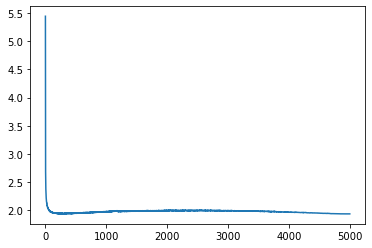

In [18]:
plt.plot(ncvis_data["kl_div"])
#plt.yscale("log")
print(f"Final KL div {ncvis_data['kl_div'][-1]}")
print(f"Best KL div at iteration {ncvis_data['kl_div'].argmin()} of value {ncvis_data['kl_div'].min()}")


### Noise but no fix Q

In [52]:
fix_Q = False
fix_noise = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               fix_noise=fix_noise,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


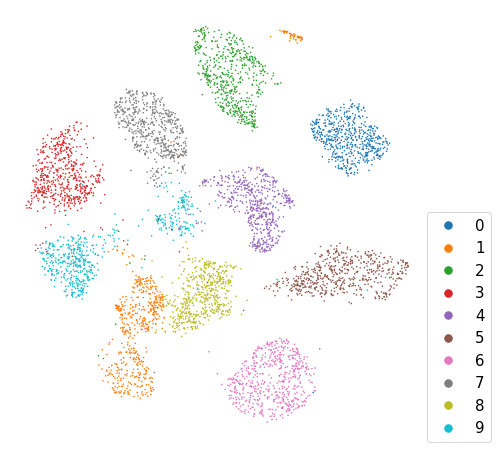

In [80]:
epoch = -1

plt.figure(figsize=(8,8))

plt.scatter(*ncvis_data["embds"][epoch].T,  c=y, s=10, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

39907.344
39117.25237241836


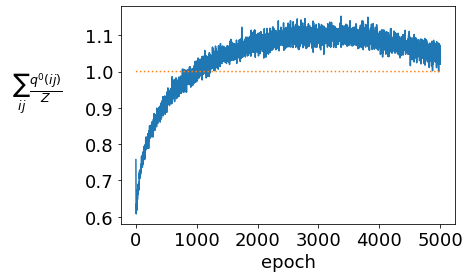

In [53]:
# relative normaliztion
start = 1
rel_norm =  ncvis_data["normalization"][start:] / np.exp(ncvis_data["qs"])[start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]


plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")



plt.xlabel("epoch")
plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

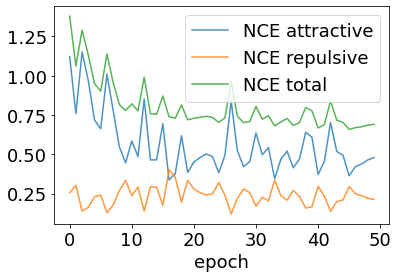

In [61]:

# the losses with true and learnt normalisation constant are very close
with sns.color_palette("tab10", n_colors=6):
    plt.plot(ncvis_data["nce_loss"][1:, 0],
             alpha=0.8,
             label="NCE attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][1:, 1],
             alpha=0.8,
             label="NCE repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][1:, 0]+ncvis_data["nce_loss"][1:, 1],
             alpha=0.8,
             label="NCE total")
    #plt.plot(ncvis_data["nce_loss_norm"][1:, 0]+ncvis_data["nce_loss_norm"][1:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()

plt.xlabel("epoch")

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_losses_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

Final KL div 1.881540687697738
Best KL div at iteration 50 of value 1.881540687697738


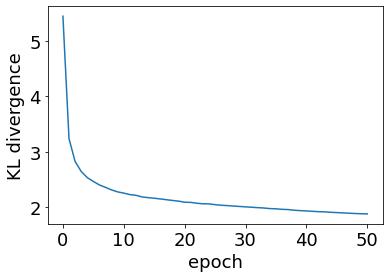

In [62]:
plt.plot(ncvis_data["kl_div"])
#plt.yscale("log")

print(f"Final KL div {ncvis_data['kl_div'][-1]}")
print(f"Best KL div at iteration {ncvis_data['kl_div'].argmin()} of value {ncvis_data['kl_div'].min()}")


plt.xlabel("epoch")
plt.ylabel("KL divergence")

plt.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_KL_div_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

### Noise and fix Q

In [24]:
fix_Q = True
fix_noise = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               fix_noise=fix_noise,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data



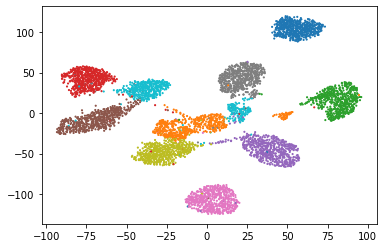

In [25]:
epoch = -1
plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=5, marker=".", cmap="tab10")






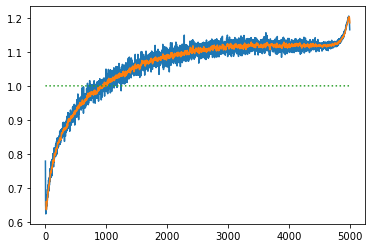

In [26]:
# relative normaliztion
rel_norm =  ncvis_data["normalization"][1:] / np.exp(ncvis_data["qs"])[1:]
plt.plot(rel_norm)
box_pts=11
box = np.ones(box_pts)/box_pts
rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)
plt.plot(np.ones(len(ncvis_data["normalization"]-1)), linestyle="dotted")

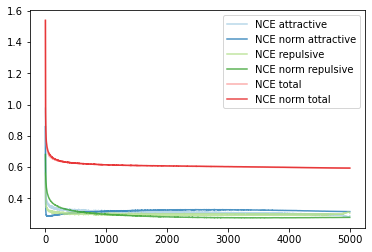

In [27]:
# the losses with true and learnt normalisation constant are very close
with sns.color_palette("Paired", n_colors=6):
    plt.plot(ncvis_data["nce_loss"][1:, 0],
             alpha=0.8,
             label="NCE attractive")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 0],
             alpha=0.8,
             label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][1:, 1],
             alpha=0.8,
             label="NCE repulsive")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 1],
             alpha=0.8,
             label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][1:, 0]+ncvis_data["nce_loss"][1:, 1],
             alpha=0.8,
             label="NCE total")
    plt.plot(ncvis_data["nce_loss_norm"][1:, 0]+ncvis_data["nce_loss_norm"][1:, 1],
             alpha=0.8,
             label="NCE norm total")

plt.legend()


Final KL div 1.927003645475601
Best KL div at iteration 4852 of value 1.9260880153100182


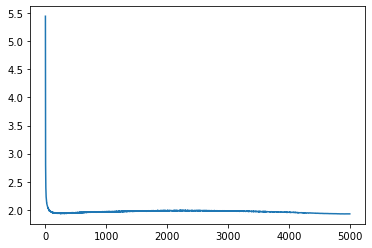

In [28]:
plt.plot(ncvis_data["kl_div"])
#plt.yscale("log")
print(f"Final KL div {ncvis_data['kl_div'][-1]}")
print(f"Best KL div at iteration {ncvis_data['kl_div'].argmin()} of value {ncvis_data['kl_div'].min()}")



## more noise

In [3]:
# parameters for all methods
n_epochs = 500
seed = 0
alpha_Q = 0.001
alpha = 1.0
log_embds = False

In [4]:
fix_Q = False
fix_noise = False

ncvis_datas = []
for n_noise in [5, 10, 15, 20, 50, 100]:
    file_name = os.path.join(root_path,
                             "pendigits",
                             f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
    try:
        ncvis_datas.append(load_dict(file_name))
    except FileNotFoundError:
        ncvisualizer = ncvis.NCVis(distance='correlation',
                                   n_epochs=n_epochs,
                                   random_seed=seed,
                                   fix_Q=fix_Q,
                                   fix_noise=fix_noise,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q)
        embd = ncvisualizer.fit_transform(x, log_embds=False)
        save_dict(ncvisualizer.aux_data, file_name)
        ncvis_datas.append(ncvisualizer.aux_data)
    print(f"done with noise {n_noise}")

done with noise 5
done with noise 10
done with noise 15
done with noise 20
done with noise 50
done with noise 100


1.7848375276832176
1.7616855632703619
1.7631669581373455
1.7309826636482804
1.7251813809200396


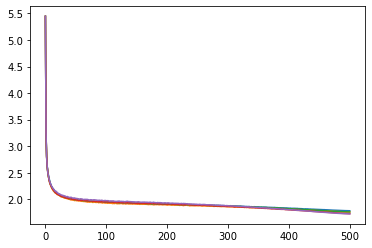

In [25]:
for data in ncvis_datas:
    plt.plot(data["kl_div"])
    print(data["kl_div"][-1])

In [17]:
# parameters for all methods
n_epochs = 500
seed = 0
n_noise = 5
alpha_Q = 0.001
alpha = 1.0



In [6]:
k = 15
knn_graph = kNN_graph(x.astype("float"),
                      k,
                      metric="euclidean").cpu().numpy().flatten()
knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*k),
                                     (np.repeat(np.arange(x.shape[0]), k),
                                      knn_graph)),
                                    shape=(len(x), len(x)))
sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()

affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)

(118278, 2)

In [34]:

## No noise, no damped Q
fix_Q = False
fix_noise = False
ncvisualizer = ncvis.NCVis(distance='correlation',
                           n_epochs=n_epochs,
                           random_seed=seed,
                           fix_Q=fix_Q,
                           fix_noise=fix_noise,
                           n_noise=n_noise,
                           alpha=alpha,
                           alpha_Q=alpha_Q)

embd = ncvisualizer.fit_transform(x,
                                  affinities = affinities,
                           log_norm=False,
                           log_nce=False,
                           log_nce_no_noise=False,
                           log_nce_norm=False,
                           log_kl=False)
ncvis_data = ncvisualizer.aux_data

affinities is not none


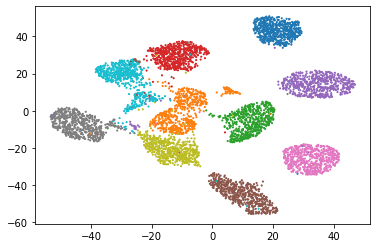

In [35]:
epoch = -1
plt.scatter(*embd.T, c=y, s=5, marker=".", cmap="tab10")

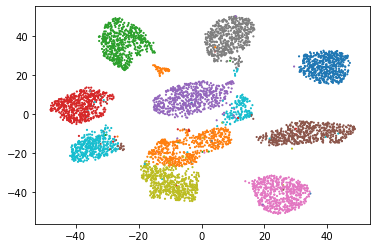

In [21]:
epoch = -1
plt.scatter(*embd.T, c=y, s=5, marker=".", cmap="tab10")

In [29]:
(ncvis_data["edges"][:, 0] == 1).sum()

17

In [12]:
118278 * 2

236556

In [30]:
sknn_graph_ncvis = scipy.sparse.coo_matrix((np.ones(len(ncvis_data["edges"])),
                                    (ncvis_data["edges"][:, 0],
                                     ncvis_data["edges"][:, 1])),
                                   shape=(len(x), len(x)))

In [31]:
sknn_graph_ncvis.maximum(sknn_graph_ncvis.T).sum()

143416.0

In [32]:
sknn_graph_ncvis.sum()

134185.0

In [33]:
sknn_graph_ncvis.max()

2.0

## No learnt normalisation

In [41]:
n_epochs=50
fix_Q = False
fix_noise = False
learn_Q  = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.pkl")
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               fix_noise=fix_noise,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data

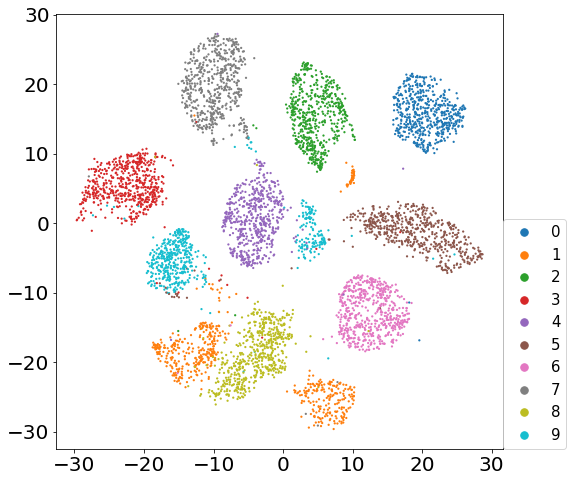

In [42]:
cmap = matplotlib.cm.get_cmap("tab10")
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

#plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

Text(0.5, 0, 'epoch')

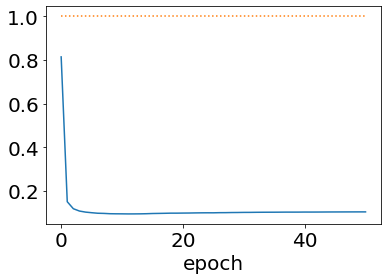

In [35]:
# relative normaliztion
start = 0
rel_norm =  ncvis_data["normalization"][start:] / (len(x) * len(x)-1)
epochs = np.arange(len(ncvis_data["normalization"]))[start:]


plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")



plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

In [36]:
ncvis_data.keys()

dict_keys(['qs', 'embds', 'edges', 'n_epochs', 'random_seed', 'distance', 'fix_noise', 'fix_Q', 'n_noise', 'n_neighbors', 'normalization', 'nce_loss', 'nce_loss_no_noise', 'nce_loss_norm', 'kl_div'])

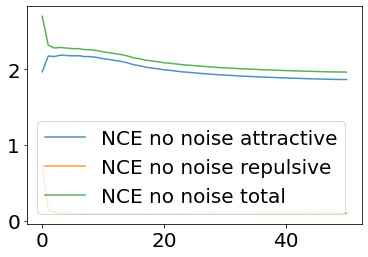

In [37]:

# the losses with true and learnt normalisation constant are very close
start = 0
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss_no_noise"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss_no_noise"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss_no_noise"][start:, 0]+ncvis_data["nce_loss_no_noise"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()

In [8]:
a, b = find_ab_params(1.0, 0.4)

In [9]:
sknn_graph = scipy.sparse.coo_matrix((np.ones(len(ncvis_data["edges"])),
                                                (ncvis_data["edges"][:, 0],
                                                 ncvis_data["edges"][:, 1])),
                                               shape=(len(x), len(x)))

In [38]:
low_pos_sims = compute_low_dim_sims(embedding1=ncvis_data["embds"][-1][sknn_graph.row],  # embd_after[graph.row],
                                    embedding2=ncvis_data["embds"][-1][sknn_graph.col],  # embd_after[graph.col],
                                    a=a,
                                    b=b,
                                    sim_func="cauchy",
                                    eps=1e-10) # not much change in the histograms for 1e-4 - 1e-10


low_pos_sims2 = low_pos_sims / ( low_pos_sims + 5)

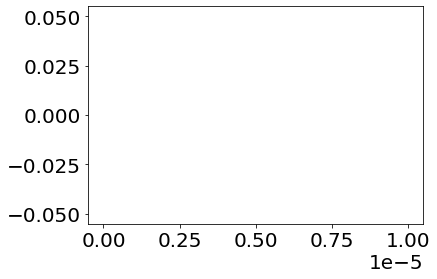

In [39]:
plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range= (0,0.00001), alpha=0.5, label=r"$\tilde{q}^0(ij)$")
_, _, _ = plt.hist(low_pos_sims2, bins=200, range= (0,0.00001), alpha=0.5, label=r"$\tilde{q}^0(ij)$")

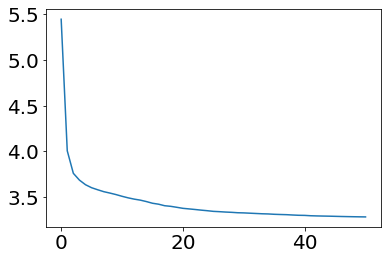

In [40]:
plt.plot(ncvis_data["kl_div"])